# Linear regression with one variable

In [1]:
%matplotlib inline
# %pylab
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T

/Users/vitormeriat/anaconda/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
data = []
with open('ex1data1.txt', 'r') as f:
    for line in f:
        data.append(list(map(float,line.strip().split(','))))
data = np.array(data)     
m = len(data)

In [17]:
print(data.shape)
print(data)

(97, 2)
[[  6.1101   17.592  ]
 [  5.5277    9.1302 ]
 [  8.5186   13.662  ]
 [  7.0032   11.854  ]
 [  5.8598    6.8233 ]
 [  8.3829   11.886  ]
 [  7.4764    4.3483 ]
 [  8.5781   12.     ]
 [  6.4862    6.5987 ]
 [  5.0546    3.8166 ]
 [  5.7107    3.2522 ]
 [ 14.164    15.505  ]
 [  5.734     3.1551 ]
 [  8.4084    7.2258 ]
 [  5.6407    0.71618]
 [  5.3794    3.5129 ]
 [  6.3654    5.3048 ]
 [  5.1301    0.56077]
 [  6.4296    3.6518 ]
 [  7.0708    5.3893 ]
 [  6.1891    3.1386 ]
 [ 20.27     21.767  ]
 [  5.4901    4.263  ]
 [  6.3261    5.1875 ]
 [  5.5649    3.0825 ]
 [ 18.945    22.638  ]
 [ 12.828    13.501  ]
 [ 10.957     7.0467 ]
 [ 13.176    14.692  ]
 [ 22.203    24.147  ]
 [  5.2524   -1.22   ]
 [  6.5894    5.9966 ]
 [  9.2482   12.134  ]
 [  5.8918    1.8495 ]
 [  8.2111    6.5426 ]
 [  7.9334    4.5623 ]
 [  8.0959    4.1164 ]
 [  5.6063    3.3928 ]
 [ 12.836    10.117  ]
 [  6.3534    5.4974 ]
 [  5.4069    0.55657]
 [  6.8825    3.9115 ]
 [ 11.708     5.3854 ]
 [ 

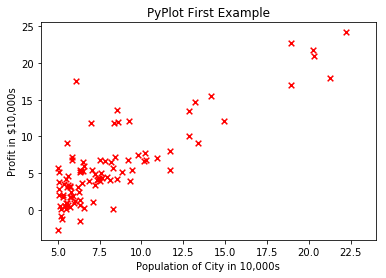

In [18]:
# Definir o gráfico
# style.use('fivethirtyeight') 
fig = plt.figure() 
ax1 = fig.add_subplot(1,1,1)

plt.scatter(data[:,0], data[:,1], s=32, c='red', marker='x')
plt.title("PyPlot First Example")
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.xlim(4, 24)
plt.show()

In [19]:
# Construir amostras e rótulos, a primeira coluna da amostra é 1
xt = np.ones((m,2))
xt[:, 1] =  data[:,0]
labelt = np.zeros((m, 1))
labelt[:, 0] = data[:, 1]